# **Analyst Consensus Model** - Capstone Project: DWS - ESADE Business School

#### **Tutor:** Jarrid Klug
#### **Members:** Alex Casas, Daniel Peace, Enric Aletà



### **Introduction**

The goal of this project is to develop a robust model to evaluate the accuracy of analyst predictions. By analyzing historical predictions and their realized values, we aim to rank analysts based on their performance and construct a weighted consensus estimate that outperforms simple averaging methods. This approach can provide valuable insights for decision-making and improve the reliability of aggregated forecasts.

**Note:**  
The dataset used in this project is **synthetic**, created to simulate real-world scenarios due to the unavailability of actual data. However, the methodology and preprocessing steps are designed to closely mimic how real data would be handled, ensuring the approach is transferable to real-world applications.

---

In [1]:
#Libraries used
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import dask.dataframe as dd

## **1) Data Adquisition & Exploration**

As mentioned above, we are using a **syntehitc dataset**, trying to mimic the real dataset. We are tying to mimic real world scenarios, but **probably we will have to improve some steps (E.g: Preprocssing) based on the imputs that you give us.**

**Note:** we are using the extension *Data Wrangler* to explore the dataset.



In [2]:
df = pd.read_csv("data/forecasts.csv")

df


,Quarter,Estimate Type,Predicted Value,Real Value,Company,Analyst,Bank,Market Cap,Sector,Start Date,Horizon,Revision Time
0,Q1 2013,Stock Price,2.651234e+01,3.127849e+01,Company5,Analyst513,JP Morgan,Mid Cap,Technology,2013-02-19,Q1,Initial
1,Q1 2013,Stock Price,2.928395e+01,3.127849e+01,Company5,Analyst513,Goldman Sachs,Mid Cap,Technology,2013-02-19,Q2,Initial
2,Q1 2013,EBITDA,1.551400e+09,1.226174e+09,Company5,Analyst513,Citi,Mid Cap,Technology,2013-02-19,Q0,Initial
3,Q1 2013,EBITDA,1.174947e+09,1.226174e+09,Company5,Analyst513,Morgan Stanley,Mid Cap,Technology,2013-02-19,Q1,Initial
4,Q1 2013,EBITDA,1.452862e+09,1.226174e+09,Company5,Analyst513,Citi,Mid Cap,Technology,2013-02-19,Q2,Initial
...,...,...,...,...,...,...,...,...,...,...,...,...
13826039,Q4 2022,EBIT,6.461027e+09,5.832162e+09,Company1000,Analyst47,Credit Suisse,Mid Cap,Real Estate,2017-05-16,Q0,Rev 2022-11-30
13826040,Q4 2022,EBIT,6.313991e+09,5.832162e+09,Company1000,Analyst682,Credit Suisse,Mid Cap,Real Estate,2018-09-24,Q0,Rev 2022-11-30
13826041,Q4 2022,EBIT,5.773240e+09,5.832162e+09,Company1000,Analyst389,Bank of America,Mid Cap,Real Estate,2013-03-18,Q0,Rev 2022-11-30
13826042,Q4 2022,EBIT,5.402767e+09,5.832162e+09,Company1000,Analyst243,Wells Fargo,Mid Cap,Real Estate,2013-09-09,Q0,Rev 2022-11-30


In [3]:
# Display the column names and data types
print("\nColumn names and data types:")
print(df.dtypes)

# Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Get basic statistics for numeric columns
print("\nBasic statistics for numeric columns:")
print(df.describe())

# Get basic statistics for categorical columns
print("\nBasic statistics for categorical columns:")
print(df.describe(include=["object"]))

# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())

# Check the unique values in each categorical column (excluding 'Company' and 'Analyst')
categorical_columns = df.select_dtypes(include=["object"]).columns
excluded_columns = ["Company", "Analyst", "Start Date", "Revision Time"]
for col in categorical_columns:
    if col not in excluded_columns:
        print(f"\nUnique values in column '{col}':")
        print(df[col].unique())

# Check the distribution of numeric columns
print("\nDistribution of numeric columns:")
for col in df.select_dtypes(include=["float64", "int64"]).columns:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(bins=10, sort=False))



Column names and data types:
Quarter             object
Estimate Type       object
Predicted Value    float64
Real Value         float64
Company             object
Analyst             object
Bank                object
Market Cap          object
Sector              object
Start Date          object
Horizon             object
Revision Time       object
dtype: object

Missing values per column:
Quarter            0
Estimate Type      0
Predicted Value    0
Real Value         0
Company            0
Analyst            0
Bank               0
Market Cap         0
Sector             0
Start Date         0
Horizon            0
Revision Time      0
dtype: int64

Basic statistics for numeric columns:
       Predicted Value    Real Value
count     1.382604e+07  1.382604e+07
mean      1.574062e+21  6.541514e+20
std       4.931830e+22  2.849649e+22
min       7.513550e-02  1.143444e-01
25%       7.377248e+01  7.336922e+01
50%       7.112862e+08  7.053009e+08
75%       2.870160e+09  2.803941e+09
max 

## **2) Preprocessing**

This section covers the core preprocessing steps applied to the synthetic dataset to prepare it for modeling.  
All transformations were designed to reflect what would be needed in a real-world project, but **specific adjustments must be made depending on the final/real dataset used**.

Key points:
- The workflow was built to be **dynamic and modular**, allowing easy adaptation if new features, analysts, or companies are introduced.
- In a real Bloomberg extract, further checks on **data consistency**, **currency normalization**, and **outlier treatment** would be necessary.
- Feature engineering steps, like **encoding categories**, **handling missing values**, and **target transformations**, were structured carefully to ensure models could generalize over time.
- **Feature selection** was dynamically applied based on feature importance to avoid overfitting and keep only impactful variables.

**Important**: Once real data is available, we recommend revisiting each preprocessing block, validating assumptions, and adapting thresholds, encodings, or treatments as necessary. We belvie that the best approach is improving the model based on the **real outputs**, so we will have to go a bit back an forth. 

---





### **2.1) Data Splits**

The dataset was split using three complementary strategies: **time-based splitting**, **rolling window backtesting**, and **time series cross-validation**.  
Each method will be applied later depending on the type of model and objective, ensuring that evaluations remain realistic and aligned with real-world forecasting challenges.

---

#### **2.1.1) Time-Based Splitting**

We split the data chronologically into training and testing sets.  
This approach is used when we want to **simulate how models would perform in a real future**, training only on past data and testing on unseen periods.

---


In [4]:
# Build the quarter_ends_map
start_date = pd.Timestamp("2013-01-01")
end_date = pd.Timestamp("2023-01-01")
trading_days = pd.date_range(start_date, end_date, freq='B')  # Business days
quarter_ends = trading_days.to_series().groupby(trading_days.to_period("Q")).last().values
quarter_ends = pd.to_datetime(quarter_ends)

# Map quarters (e.g., "Q1 2013") to their end-of-quarter dates
quarter_ends_map = {
    f"Q{d.quarter} {d.year}": d
    for d in quarter_ends
}

# Convert the Quarter column using the quarter_ends_map
df['Quarter'] = df['Quarter'].map(quarter_ends_map)

# Check for unmapped values
if df['Quarter'].isnull().any():
    print("Warning: Some Quarter values could not be mapped. Check the input data.")
    print(df[df['Quarter'].isnull()])

# Define time-based splits
train = df[(df['Quarter'] >= '2013-01-01') & (df['Quarter'] <= '2020-12-31')]
validate = df[(df['Quarter'] >= '2021-01-01') & (df['Quarter'] <= '2021-12-31')]
test = df[(df['Quarter'] >= '2022-01-01') & (df['Quarter'] <= '2022-12-31')]

print(f"Training set: {train.shape}")
print(f"Validation set: {validate.shape}")
print(f"Test set: {test.shape}")

Training set: (9666035, 12)
Validation set: (2377581, 12)
Test set: (1782428, 12)


#### **2.1.2) Rolling Windows Backtesting**

We trained and tested the model across **moving time windows**,  to **mimic live model performance** as new data becomes available and conditions evolve.

This method **tests model stability over time**, not just a single train/test split.

---





In [5]:
def rolling_window_splits(df, start_train, end_train, test_window, max_splits=2):
    """
    Generate rolling window train-test splits for actual data, limited to a maximum number of splits.
    """
    splits = []
    current_train_end = pd.to_datetime(end_train)  # Convert to datetime
    split_count = 0

    while current_train_end + test_window <= df['Quarter'].max() and split_count < max_splits:
        # Define train and test sets
        train_set = df[(df['Quarter'] >= pd.to_datetime(start_train)) & (df['Quarter'] <= current_train_end)]
        test_set = df[(df['Quarter'] > current_train_end) & (df['Quarter'] <= current_train_end + test_window)]

        splits.append((train_set, test_set))

        # Move the rolling window forward
        current_train_end += test_window
        split_count += 1

    return splits

# Adjusted parameters for 2 splits
rolling_splits = rolling_window_splits(
    df,
    start_train='2013-01-01',  # Start of the training period
    end_train='2018-12-31',    # End of the initial training period (adjusted earlier)
    test_window=pd.Timedelta(days=365),  # 1-year test window
    max_splits=2  # Limit to 2 splits
)

# Print the number of splits and the size of each split
print(f"Number of rolling splits: {len(rolling_splits)}")
for i, (train, test) in enumerate(rolling_splits):  # Show all splits
    print(f"Split {i + 1} - Train: {train.shape}, Test: {test.shape}")


Number of rolling splits: 2
Split 1 - Train: (5458597, 12), Test: (1958952, 12)
Split 2 - Train: (7417549, 12), Test: (1663403, 12)


#### **2.1.3) Time Series Cross-Validation**

We applied **TimeSeriesSplit**, which **respects temporal order**  while creating multiple train/test folds, helping us **evaluate model consistency** across different time periods.

This technique strengthens the **robustness** of the results.

---




In [6]:
from sklearn.model_selection import TimeSeriesSplit

# Define features and target
X = train.drop(columns=['Real Value'])  # Replace 'Real Value' with your target column
y = train['Real Value']

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Generate splits
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold + 1}:")
    print(f"Train indices: {train_idx[:5]}...{train_idx[-5:]}, Test indices: {test_idx[:5]}...{test_idx[-5:]}")
    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")

Fold 1:
Train indices: [0 1 2 3 4]...[1236254 1236255 1236256 1236257 1236258], Test indices: [1236259 1236260 1236261 1236262 1236263]...[2472512 2472513 2472514 2472515 2472516]
Train size: 1236259, Test size: 1236258
Fold 2:
Train indices: [0 1 2 3 4]...[2472512 2472513 2472514 2472515 2472516], Test indices: [2472517 2472518 2472519 2472520 2472521]...[3708770 3708771 3708772 3708773 3708774]
Train size: 2472517, Test size: 1236258
Fold 3:
Train indices: [0 1 2 3 4]...[3708770 3708771 3708772 3708773 3708774], Test indices: [3708775 3708776 3708777 3708778 3708779]...[4945028 4945029 4945030 4945031 4945032]
Train size: 3708775, Test size: 1236258
Fold 4:
Train indices: [0 1 2 3 4]...[4945028 4945029 4945030 4945031 4945032], Test indices: [4945033 4945034 4945035 4945036 4945037]...[6181286 6181287 6181288 6181289 6181290]
Train size: 4945033, Test size: 1236258
Fold 5:
Train indices: [0 1 2 3 4]...[6181286 6181287 6181288 6181289 6181290], Test indices: [6181291 6181292 6181293 6

### **2.2) Categorical Variable Preprocessing**

To prepare the dataset for modeling, we applied **different encoding strategies** based on the type of categorical variable:

- **Low-cardinality variables** (few unique values) were **One-Hot Encoded** to avoid introducing artificial order.
- **High-cardinality variables** (many unique values, like Company or Analyst) were **Label Encoded** to maintain efficiency and avoid explosion of dimensions.

We first **fitted the encoders on the full dataset** (train + validate + test) to ensure consistent mappings across splits.  
Then, we **transformed each split separately**, maintaining temporal integrity and preparing clean inputs for modeling.

For **rolling window splits**, we dynamically applied the same logic to each training/testing pair to stay aligned with real-world deployment needs.

---


In [7]:
# ---------------------------
# Categorical Variable Handling (Updated for Splits)
# ---------------------------

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

def preprocess_categorical_variables(df, low_cardinality_columns, high_cardinality_columns, ohe=None):
    """
    Preprocess categorical variables by applying one-hot encoding to low-cardinality columns
    and label encoding to high-cardinality columns.
    """
    label_encoders = {}  # Dictionary to store LabelEncoders

    # 1. Validate and filter columns
    low_cardinality_columns = [col for col in low_cardinality_columns if col in df.columns]
    high_cardinality_columns = [col for col in high_cardinality_columns if col in df.columns]

    # 2. One-Hot Encoding for Low-Cardinality Categorical Variables
    if low_cardinality_columns:
        if ohe is None:
            print(f"Fitting OneHotEncoder on columns: {low_cardinality_columns}")
            ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
            encoded_features = ohe.fit_transform(df[low_cardinality_columns])
        else:
            print(f"Transforming data using existing OneHotEncoder.")
            encoded_features = ohe.transform(df[low_cardinality_columns])

        # Convert the encoded features into a DataFrame
        encoded_df = pd.DataFrame(
            encoded_features, 
            columns=ohe.get_feature_names_out(low_cardinality_columns),
            index=df.index  # Ensure the index matches the original DataFrame
        )

        # Add the encoded features back to the original DataFrame
        df = pd.concat([df, encoded_df], axis=1)

        # Drop the original low-cardinality categorical columns
        df = df.drop(columns=low_cardinality_columns)
        print(f"One-hot encoding completed. Encoded columns: {list(encoded_df.columns)}")
    else:
        print("No low-cardinality columns found for one-hot encoding.")

    # 3. Label Encoding for High-Cardinality Categorical Variables
    for col in high_cardinality_columns:
        if col in df.columns:  # Ensure the column exists
            print(f"Label encoding column: {col}")
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le  # Save the encoder for inverse transformation if needed
        else:
            print(f"Column {col} not found in the DataFrame. Skipping label encoding.")

    return df, ohe, label_encoders


def preprocess_splits(train, validate=None, test=None, low_cardinality_columns=None, high_cardinality_columns=None):
    """
    Apply categorical preprocessing to train, validate, and test splits.
    """
    if low_cardinality_columns is None or high_cardinality_columns is None:
        raise ValueError("Both low_cardinality_columns and high_cardinality_columns must be provided.")

    print("Preprocessing training set...")
    train, ohe, train_label_encoders = preprocess_categorical_variables(
        train, low_cardinality_columns, high_cardinality_columns
    )

    if validate is not None:
        print("Preprocessing validation set...")
        validate, _, _ = preprocess_categorical_variables(
            validate, low_cardinality_columns, high_cardinality_columns, ohe=ohe
        )

    if test is not None:
        print("Preprocessing test set...")
        test, _, _ = preprocess_categorical_variables(
            test, low_cardinality_columns, high_cardinality_columns, ohe=ohe
        )

    return train, validate, test, ohe


# ---------------------------
# Main Workflow
# ---------------------------

# Define categorical columns
categorical_columns = ["Quarter", "Estimate Type", "Bank", "Market Cap", "Sector", "Horizon"]
high_cardinality_columns = ["Company", "Analyst"]

# Ensure the columns exist in the DataFrame
existing_columns = [col for col in categorical_columns if col in df.columns]
low_cardinality_columns = [col for col in existing_columns if col not in high_cardinality_columns]

# Combine all splits to fit the OneHotEncoder
combined_df = pd.concat([train, validate, test], axis=0)

# Fit the OneHotEncoder on the combined dataset
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
ohe.fit(combined_df[low_cardinality_columns])

# Transform each split using the fitted encoder
train_encoded = ohe.transform(train[low_cardinality_columns])
validate_encoded = ohe.transform(validate[low_cardinality_columns])
test_encoded = ohe.transform(test[low_cardinality_columns])

# Convert the encoded features into DataFrames
train_encoded_df = pd.DataFrame(train_encoded, columns=ohe.get_feature_names_out(low_cardinality_columns), index=train.index)
validate_encoded_df = pd.DataFrame(validate_encoded, columns=ohe.get_feature_names_out(low_cardinality_columns), index=validate.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=ohe.get_feature_names_out(low_cardinality_columns), index=test.index)

# Add the encoded features back to the original DataFrames
train = pd.concat([train.reset_index(drop=True), train_encoded_df.reset_index(drop=True)], axis=1).drop(columns=low_cardinality_columns)
validate = pd.concat([validate.reset_index(drop=True), validate_encoded_df.reset_index(drop=True)], axis=1).drop(columns=low_cardinality_columns)
test = pd.concat([test.reset_index(drop=True), test_encoded_df.reset_index(drop=True)], axis=1).drop(columns=low_cardinality_columns)

# If using rolling window splits, preprocess each split dynamically
for i, (train_split, test_split) in enumerate(rolling_splits):
    print(f"\nPreprocessing Split {i + 1}...")
    train_split, _, test_split, _ = preprocess_splits(
        train_split, test=test_split, low_cardinality_columns=low_cardinality_columns, high_cardinality_columns=high_cardinality_columns
    )


Preprocessing Split 1...
Preprocessing training set...
Fitting OneHotEncoder on columns: ['Quarter', 'Estimate Type', 'Bank', 'Market Cap', 'Sector', 'Horizon']
One-hot encoding completed. Encoded columns: ['Quarter_2013-06-28T00:00:00.000000000', 'Quarter_2013-09-30T00:00:00.000000000', 'Quarter_2013-12-31T00:00:00.000000000', 'Quarter_2014-03-31T00:00:00.000000000', 'Quarter_2014-06-30T00:00:00.000000000', 'Quarter_2014-09-30T00:00:00.000000000', 'Quarter_2014-12-31T00:00:00.000000000', 'Quarter_2015-03-31T00:00:00.000000000', 'Quarter_2015-06-30T00:00:00.000000000', 'Quarter_2015-09-30T00:00:00.000000000', 'Quarter_2015-12-31T00:00:00.000000000', 'Quarter_2016-03-31T00:00:00.000000000', 'Quarter_2016-06-30T00:00:00.000000000', 'Quarter_2016-09-30T00:00:00.000000000', 'Quarter_2016-12-30T00:00:00.000000000', 'Quarter_2017-03-31T00:00:00.000000000', 'Quarter_2017-06-30T00:00:00.000000000', 'Quarter_2017-09-29T00:00:00.000000000', 'Quarter_2017-12-29T00:00:00.000000000', 'Quarter_2018

c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


One-hot encoding completed. Encoded columns: ['Quarter_2013-06-28T00:00:00.000000000', 'Quarter_2013-09-30T00:00:00.000000000', 'Quarter_2013-12-31T00:00:00.000000000', 'Quarter_2014-03-31T00:00:00.000000000', 'Quarter_2014-06-30T00:00:00.000000000', 'Quarter_2014-09-30T00:00:00.000000000', 'Quarter_2014-12-31T00:00:00.000000000', 'Quarter_2015-03-31T00:00:00.000000000', 'Quarter_2015-06-30T00:00:00.000000000', 'Quarter_2015-09-30T00:00:00.000000000', 'Quarter_2015-12-31T00:00:00.000000000', 'Quarter_2016-03-31T00:00:00.000000000', 'Quarter_2016-06-30T00:00:00.000000000', 'Quarter_2016-09-30T00:00:00.000000000', 'Quarter_2016-12-30T00:00:00.000000000', 'Quarter_2017-03-31T00:00:00.000000000', 'Quarter_2017-06-30T00:00:00.000000000', 'Quarter_2017-09-29T00:00:00.000000000', 'Quarter_2017-12-29T00:00:00.000000000', 'Quarter_2018-03-30T00:00:00.000000000', 'Quarter_2018-06-29T00:00:00.000000000', 'Quarter_2018-09-28T00:00:00.000000000', 'Quarter_2018-12-31T00:00:00.000000000', 'Estimate T

c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


One-hot encoding completed. Encoded columns: ['Quarter_2013-06-28T00:00:00.000000000', 'Quarter_2013-09-30T00:00:00.000000000', 'Quarter_2013-12-31T00:00:00.000000000', 'Quarter_2014-03-31T00:00:00.000000000', 'Quarter_2014-06-30T00:00:00.000000000', 'Quarter_2014-09-30T00:00:00.000000000', 'Quarter_2014-12-31T00:00:00.000000000', 'Quarter_2015-03-31T00:00:00.000000000', 'Quarter_2015-06-30T00:00:00.000000000', 'Quarter_2015-09-30T00:00:00.000000000', 'Quarter_2015-12-31T00:00:00.000000000', 'Quarter_2016-03-31T00:00:00.000000000', 'Quarter_2016-06-30T00:00:00.000000000', 'Quarter_2016-09-30T00:00:00.000000000', 'Quarter_2016-12-30T00:00:00.000000000', 'Quarter_2017-03-31T00:00:00.000000000', 'Quarter_2017-06-30T00:00:00.000000000', 'Quarter_2017-09-29T00:00:00.000000000', 'Quarter_2017-12-29T00:00:00.000000000', 'Quarter_2018-03-30T00:00:00.000000000', 'Quarter_2018-06-29T00:00:00.000000000', 'Quarter_2018-09-28T00:00:00.000000000', 'Quarter_2018-12-31T00:00:00.000000000', 'Quarter_20

### **2.3) Numeric Variable Preprocessing**

We standardized the numeric variables to **stabilize model training and improve convergence**.

- **Highly skewed features** were **log-transformed** or **power-transformed** depending on the direction of skewness.
- Afterwards, **standard scaling** was applied to ensure **zero mean and unit variance** across all numeric inputs.

The transformation strategy was consistently applied across **training, validation, and test splits**, and dynamically across **rolling windows**, to mimic real-world deployment and avoid data leakage.

---



In [8]:
# -----------------------------
# Numeric Variable Handling: Normalization
# -----------------------------

from sklearn.preprocessing import StandardScaler, PowerTransformer

def normalize_numeric_columns(df, numeric_columns):
    """
    Normalize numeric columns based on their skewness.
    Applies log transformation for highly skewed columns and standard scaling for all.
    """
    # Ensure the columns exist in the DataFrame
    existing_numeric_columns = [col for col in numeric_columns if col in df.columns]

    if not existing_numeric_columns:
        print("No numeric columns found for normalization.")
        return df

    # Analyze skewness of numeric columns
    skewness = df[existing_numeric_columns].skew()
    print("\nSkewness of numeric columns:")
    print(skewness)

    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Apply transformations based on skewness
    for col in existing_numeric_columns:
        if skewness[col] > 1:  # Highly skewed
            print(f"Applying log1p transformation to '{col}' due to high skewness ({skewness[col]:.2f}).")
            df.loc[:, col] = np.log1p(df[col].clip(lower=0))  # Clip to avoid log of negative values
        elif skewness[col] < -1:  # Highly negatively skewed
            print(f"Applying PowerTransformer to '{col}' due to high negative skewness ({skewness[col]:.2f}).")
            pt = PowerTransformer(method='yeo-johnson')  # Handles negative values
            df.loc[:, col] = pt.fit_transform(df[[col]])

    # Standard scaling for all numeric columns
    print("Applying standard scaling to numeric columns.")
    scaler = StandardScaler()
    df.loc[:, existing_numeric_columns] = scaler.fit_transform(df[existing_numeric_columns])

    return df

# -----------------------------
# Apply Normalization to Splits
# -----------------------------

def normalize_splits(train, validate=None, test=None, numeric_columns=None):
    """
    Normalize numeric columns for train, validate, and test splits.
    """
    print("Normalizing training set...")
    train = normalize_numeric_columns(train, numeric_columns)

    if validate is not None:
        print("Normalizing validation set...")
        validate = normalize_numeric_columns(validate, numeric_columns)

    if test is not None:
        print("Normalizing test set...")
        test = normalize_numeric_columns(test, numeric_columns)

    return train, validate, test

# Define numeric columns
numeric_columns = ["Predicted Value", "Real Value"]

# Example: Apply normalization to time-based splits
train, validate, test = normalize_splits(train, validate, test, numeric_columns=numeric_columns)

# If using rolling window splits or cross-validation, normalize each split dynamically
# Example for rolling window splits:
for i, (train_split, test_split) in enumerate(rolling_splits):
    print(f"\nNormalizing Split {i + 1}...")
    train_split, _, test_split = normalize_splits(train_split, test=test_split, numeric_columns=numeric_columns)

Normalizing training set...

Skewness of numeric columns:
Predicted Value    25.266050
Real Value         35.108843
dtype: float64
Applying log1p transformation to 'Predicted Value' due to high skewness (25.27).
Applying log1p transformation to 'Real Value' due to high skewness (35.11).
Applying standard scaling to numeric columns.
Normalizing validation set...

Skewness of numeric columns:
Predicted Value    13.113143
Real Value         18.129232
dtype: float64
Applying log1p transformation to 'Predicted Value' due to high skewness (13.11).
Applying log1p transformation to 'Real Value' due to high skewness (18.13).
Applying standard scaling to numeric columns.
Normalizing test set...

Skewness of numeric columns:
Predicted Value    15.870497
Real Value          9.029595
dtype: float64
Applying log1p transformation to 'Predicted Value' due to high skewness (15.87).
Applying log1p transformation to 'Real Value' due to high skewness (9.03).
Applying standard scaling to numeric columns.



In [9]:
# -----------------------------
# Numeric Variable Handling: Improved Normalization
# -----------------------------

from sklearn.preprocessing import StandardScaler
import numpy as np

def normalize_numeric_columns(df, numeric_columns):
    """
    Normalize numeric columns based on their skewness.
    Applies log transformation for highly skewed columns and standard scaling for all.
    """
    # Ensure the columns exist in the DataFrame
    existing_numeric_columns = [col for col in numeric_columns if col in df.columns]

    if not existing_numeric_columns:
        print("No numeric columns found for normalization.")
        return df

    # Analyze skewness of numeric columns
    skewness = df[existing_numeric_columns].skew()
    print("\nSkewness of numeric columns:")
    print(skewness)

    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Apply transformations based on skewness
    for col in existing_numeric_columns:
        if skewness[col] > 1:  # Highly skewed
            print(f"Applying log1p transformation to '{col}' due to high skewness ({skewness[col]:.2f}).")
            df[col] = np.log1p(df[col].clip(lower=0))  # Clip to avoid log of negative values

    # Standard scaling for all numeric columns
    print("Applying standard scaling to numeric columns.")
    scaler = StandardScaler()
    df[existing_numeric_columns] = scaler.fit_transform(df[existing_numeric_columns])

    return df

# -----------------------------
# Apply Normalization to Splits
# -----------------------------

def normalize_splits(train, validate=None, test=None, numeric_columns=None):
    """
    Normalize numeric columns for train, validate, and test splits.
    """
    print("Normalizing training set...")
    train = normalize_numeric_columns(train, numeric_columns)

    if validate is not None:
        print("Normalizing validation set...")
        validate = normalize_numeric_columns(validate, numeric_columns)

    if test is not None:
        print("Normalizing test set...")
        test = normalize_numeric_columns(test, numeric_columns)

    return train, validate, test

# Define numeric columns
numeric_columns = ["Predicted Value", "Real Value"]

# Example: Apply normalization to time-based splits
train, validate, test = normalize_splits(train, validate, test, numeric_columns=numeric_columns)

# If using rolling window splits or cross-validation, normalize each split dynamically
# Example for rolling window splits:
for i, (train_split, test_split) in enumerate(rolling_splits):
    print(f"\nNormalizing Split {i + 1}...")
    train_split, _, test_split = normalize_splits(train_split, test=test_split, numeric_columns=numeric_columns)

Normalizing training set...

Skewness of numeric columns:
Predicted Value   -0.001196
Real Value        -0.037251
dtype: float64
Applying standard scaling to numeric columns.
Normalizing validation set...

Skewness of numeric columns:
Predicted Value    0.609657
Real Value         0.558918
dtype: float64
Applying standard scaling to numeric columns.
Normalizing test set...

Skewness of numeric columns:
Predicted Value    0.381582
Real Value         0.311950
dtype: float64
Applying standard scaling to numeric columns.

Normalizing Split 1...
Normalizing training set...

Skewness of numeric columns:
Predicted Value    22.835958
Real Value         31.165042
dtype: float64
Applying log1p transformation to 'Predicted Value' due to high skewness (22.84).
Applying log1p transformation to 'Real Value' due to high skewness (31.17).
Applying standard scaling to numeric columns.
Normalizing test set...

Skewness of numeric columns:
Predicted Value    12.924254
Real Value         18.015304
dtype: 


### **2.4) Feature Engineering**

In this step, we created **new features** that aim to capture **richer patterns** beyond the raw data:

- **Interaction Features**: Combine existing categories (e.g., Sector + Market Cap) to detect cross-effects that a model might miss.
- **Error-Based Features**: Compute absolute and relative errors to measure historical analyst precision.
- **Logarithmic Ratios**: Stabilize scale differences between predicted and real values.

These engineered variables provide the model with **deeper relationships and contextual signals**, helping it generalize better.

> **Important**: With the **real dataset**, **this step should be revisited carefully**. New, more insightful combinations or dynamic features (e.g., momentum, recent performance, volatility measures) could significantly boost model performance.

We applied this transformation systematically across **all splits** to ensure consistency and avoid data leakage during validation.

---



In [10]:
def feature_engineering(df):
    """
    Perform feature engineering on the given DataFrame.
    Includes interaction features, error-based features, and logarithmic ratios.
    """
    # Create a copy of the DataFrame to avoid modifying the original slice
    df = df.copy()

    # Interaction Features
    if "Sector" in df.columns and "Market Cap" in df.columns:
        df.loc[:, "Sector_MarketCap"] = df["Sector"] + "_" + df["Market Cap"]
    if "Horizon" in df.columns and "Estimate Type" in df.columns:
        df.loc[:, "Horizon_EstimateType"] = df["Horizon"] + "_" + df["Estimate Type"]
    if "Analyst" in df.columns and "Sector" in df.columns:
        df.loc[:, "Analyst_Sector"] = df["Analyst"] + "_" + df["Sector"]
    if "Quarter" in df.columns and "Market Cap" in df.columns:
        df.loc[:, "Quarter_MarketCap"] = df["Quarter"].astype(str) + "_" + df["Market Cap"]

    # Numeric Interaction Features
    if "Predicted Value" in df.columns and "Real Value" in df.columns:
        df.loc[:, "Predicted_Real_Interaction"] = df["Predicted Value"] * df["Real Value"]
        df.loc[:, "Predicted_Real_Ratio"] = df["Predicted Value"] / (df["Real Value"] + 1e-6)  # Avoid division by zero

    # Error-Based Features
    if "Predicted Value" in df.columns and "Real Value" in df.columns:
        df.loc[:, "Absolute_Error"] = abs(df["Predicted Value"] - df["Real Value"])
        df.loc[:, "Relative_Error"] = df["Absolute_Error"] / (abs(df["Real Value"]) + 1e-6)

    # Logarithmic Ratios
    if "Predicted Value" in df.columns and "Real Value" in df.columns:
        df.loc[:, "Log_Ratio"] = np.log1p(df["Predicted Value"]) - np.log1p(df["Real Value"])

    return df


def apply_feature_engineering_to_splits(train, validate=None, test=None, rolling_splits=None):
    """
    Apply feature engineering to train, validate, and test splits.
    Handles rolling window splits if provided.
    """
    # Apply to train, validate, and test splits
    print("Applying feature engineering to training set...")
    train = feature_engineering(train)

    if validate is not None:
        print("Applying feature engineering to validation set...")
        validate = feature_engineering(validate)

    if test is not None:
        print("Applying feature engineering to test set...")
        test = feature_engineering(test)

    # Apply to rolling window splits if provided
    if rolling_splits is not None:
        for i, (train_split, test_split) in enumerate(rolling_splits):
            print(f"\nApplying feature engineering to Rolling Split {i + 1}...")
            train_split = feature_engineering(train_split)
            test_split = feature_engineering(test_split)
            rolling_splits[i] = (train_split, test_split)

    return train, validate, test, rolling_splits


# Apply feature engineering to the splits
train, validate, test, rolling_splits = apply_feature_engineering_to_splits(
    train=train,
    validate=validate,
    test=test,
    rolling_splits=rolling_splits  # Pass rolling splits if applicable
)

Applying feature engineering to training set...


c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applying feature engineering to validation set...


c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applying feature engineering to test set...


c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



Applying feature engineering to Rolling Split 1...

Applying feature engineering to Rolling Split 2...




### **2.5) Feature Selection**

Before building predictive models, we wanted to check the Feature Improtance to see if we could **reduce noise** and **focus on the most relevant features**.

The steps we followed:

---

#### **2.5.1) Correlation Analysis (Exploratory Step)**

First, we computed the **correlation between all numeric variables and the target (`Real Value`)**.

This step provided early intuition about which variables might have the strongest linear relationships with the outcome.  
Although correlation analysis is **not sufficient alone** for feature selection, it helped **detect obvious non-informative or redundant variables**.

---

#### **2.5.2) Building the Full Feature Matrix**

Next, we **engineered a full design matrix** containing:

- **One-hot encoded categorical variables** (Sector, Market Cap, Estimate Type, Horizon)
- **Numeric variables** (Revision Months, Analyst Performance Score)
- **Interaction features** (e.g., Analyst-Sector combinations)

This resulted in a **high-dimensional sparse matrix** suitable for linear modeling.

---

#### **2.5.3) Fitting a Ridge Model for Feature Importance**

To select the most predictive features, we trained a **Ridge regression model** on the full design matrix:

- Ridge regression naturally **shrinks** the coefficients of less important features toward zero.
- We analyzed the **absolute value of the coefficients** to rank feature importance.

---

#### **2.5.4) Selecting Features Based on Importance Threshold**

Features with very small coefficients (absolute value below a predefined threshold, e.g., 0.05) were considered **low-importance** and excluded.

This **filtered feature set** ensures that the final models:

- Focus on the strongest signals
- Avoid overfitting due to irrelevant or noisy variables
- Remain computationally efficient for training and cross-validation

---

#### **2.5.5) Conclusions:**  
By combining **correlation analysis** and **Ridge-based feature importance**, we selected a robust set of features optimized for performance and generalization, ready for the modeling phase.

---



In [ ]:

def show_all_correlations(df, target_column):
    """
    Displays the correlation of all numeric features with the target column, sorted by absolute correlation.
    """
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Get correlations with the target column
    target_correlation = correlation_matrix[target_column].drop(target_column)  # Exclude self-correlation

    # Sort by absolute correlation values
    sorted_correlations = target_correlation.abs().sort_values(ascending=False)

    # Display all correlations
    print(f"Correlation of all numeric features with '{target_column}':")
    print(sorted_correlations)

    return sorted_correlations

# Apply correlation analysis to the dataset
numeric_df = df.select_dtypes(include=["float64", "int64"])  # Select only numeric columns
target_column = "Real Value"  # Replace with your target column
all_correlations = show_all_correlations(numeric_df, target_column)

Correlation of all numeric features with 'Real Value':
Predicted Value    0.62378
Name: Real Value, dtype: float64


**Explanation:**

The correlation between Predicted Value and Real Value is 0.62, showing a moderately strong relationship: predictions capture part of the real outcome but still leave significant unexplained variance. This confirms the model has a solid base but highlights room for improvement.

In [13]:
# Step 1: Build the quarter_ends_map (if using time-based splits)
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

# Define quarter-end mapping
start_date = pd.Timestamp("2013-01-01")
end_date = pd.Timestamp("2023-01-01")
trading_days = pd.date_range(start_date, end_date, freq='B')  # Business days
quarter_ends = trading_days.to_series().groupby(trading_days.to_period("Q")).last().values
quarter_ends = pd.to_datetime(quarter_ends)

quarter_ends_map = {
    f"Q{d.quarter} {d.year}": d
    for d in quarter_ends
}

In [ ]:
# Step 2: Preprocess the data and compute PctErr
from support_functions import assign_rev_bucket

# Load the dataset
df = pd.read_csv("data/forecasts.csv")

# Filter rows with non-null Real Value
df_reg = df[df["Real Value"].notnull()].copy()

# Assign revision buckets and map to numeric months
df_reg = assign_rev_bucket(df_reg, quarter_ends_map)
df_reg["RevMonths"] = df_reg["RevBucket"].map({"Rev 3m": 3, "Rev 2m": 2, "Rev 1m": 1})

# Compute percentage error (PctErr) as the target variable
EPS = 1e-6
df_reg["PctErr"] = (
    (df_reg["Predicted Value"] - df_reg["Real Value"]).abs() 
    / (df_reg["Real Value"].abs() + EPS)
)

# Display training rows and a sample of the data
print("\nTraining rows:", len(df_reg))
print("\nSample of the data:")
print(df_reg[["Company", "Analyst", "Estimate Type", "Horizon", "RevBucket", "PctErr"]].head())


Training rows: 10296889

Sample of the data:
        Company    Analyst Estimate Type Horizon RevBucket    PctErr
2946  Company18  Analyst27   Stock Price      Q0    Rev 2m  0.037130
2947  Company18  Analyst27   Stock Price      Q1    Rev 2m  0.056264
2948  Company18  Analyst27   Stock Price      Q2    Rev 2m  0.028828
2949  Company18  Analyst27        EBITDA      Q0    Rev 2m  0.033488
2950  Company18  Analyst27        EBITDA      Q1    Rev 2m  0.023862


**Explanation**

The dataset contains over 10 million forecasts, each linked to a company, an analyst, a metric (e.g., stock price, EBITDA), a horizon (e.g., Q0, Q1), and a revision bucket (how close it was to the earnings release). The PctErr column measures the analyst's error for each forecast, setting the foundation for building models to predict accuracy and score analysts.


In [15]:
# Step 2.1: Refine Analyst Performance Metric
# Compute mean PctErr for each analyst
analyst_performance = df_reg.groupby("Analyst")["PctErr"].mean().rename("Analyst_Performance_Score")

# Merge the performance score back into the main DataFrame
df_reg = df_reg.merge(analyst_performance, on="Analyst", how="left")

# Drop the old Analyst_Performance column if it exists
if "Analyst_Performance" in df_reg.columns:
    df_reg = df_reg.drop(columns=["Analyst_Performance"])

# Verify the new feature
print("\nSample of refined Analyst Performance Scores:")
print(df_reg[["Analyst", "Analyst_Performance_Score"]].drop_duplicates().head(10))


Sample of refined Analyst Performance Scores:
         Analyst  Analyst_Performance_Score
0      Analyst27                   0.182277
13    Analyst410                   0.353029
25    Analyst181                   0.245850
49    Analyst233                   0.190670
73    Analyst228                   0.510882
109   Analyst366                   0.266428
1309  Analyst513                   0.262294
1333   Analyst21                   0.187141
1364  Analyst487                   0.346553
1406  Analyst286                   0.195914


**Explanation:**

Each analyst was assigned a performance score based on their average percentage error (PctErr) across all forecasts. A lower score means more accurate predictions, allowing us to objectively compare analysts and later use this as a feature in our models.


In [16]:
# Step 3: Prepare the sparse design matrix

# Ensure the RevBucket column exists
if "RevBucket" not in df_reg.columns:
    rev_bucket_output = assign_rev_bucket(df_reg, quarter_ends_map)
    if isinstance(rev_bucket_output, pd.DataFrame):
        df_reg["RevBucket"] = rev_bucket_output["RevBucket"]
    else:
        df_reg["RevBucket"] = rev_bucket_output
    print("Recomputed RevBucket column.")

# Ensure the RevMonths column exists
if "RevMonths" not in df_reg.columns:
    df_reg["RevMonths"] = df_reg["RevBucket"].map({"Rev 3m": 3, "Rev 2m": 2, "Rev 1m": 1})
    print("Recomputed RevMonths column.")

# Step 3.1: Refine Analyst Performance Metric (ensure it's created before using as a feature)
if "Analyst_Performance_Score" not in df_reg.columns:
    analyst_performance = df_reg.groupby("Analyst")["PctErr"].mean().rename("Analyst_Performance_Score")
    df_reg = df_reg.merge(analyst_performance, on="Analyst", how="left")
    print("Computed Analyst_Performance_Score.")

# === Additional preprocessing enhancements ===

# 1. Clip extreme PctErr values (top 1%)
df_reg["PctErr"] = df_reg["PctErr"].clip(upper=df_reg["PctErr"].quantile(0.99))

# 2. Replace rare Analysts and Companies with "Other" to reduce high cardinality
min_count = 100
for col in ["Analyst", "Company"]:
    top_categories = df_reg[col].value_counts()
    rare_categories = top_categories[top_categories < min_count].index
    df_reg[col] = df_reg[col].where(~df_reg[col].isin(rare_categories), other="Other")

# 3. Optional time feature: quarters since 2013 (for time-based modeling)
df_reg["Quarter_Ordinal"] = pd.to_datetime(df_reg["Quarter"], errors='coerce')
df_reg["Quarter_Ordinal"] = (df_reg["Quarter_Ordinal"] - pd.Timestamp("2013-01-01")).dt.days // 90


# Step 3.2: Feature Engineering - Add Interaction Terms
def add_interaction_terms(df):
    """Add interaction terms to the DataFrame."""
    # Round Analyst_Performance_Score to 7 decimals
    if "Analyst_Performance_Score" in df.columns:
        df["Analyst_Performance_Score_Rounded"] = df["Analyst_Performance_Score"].round(7).astype(str)

    # Interaction between Analyst Performance Score and Sector
    if "Analyst_Performance_Score_Rounded" in df.columns and "Sector" in df.columns:
        df["Analyst_Sector_Interaction"] = df["Analyst_Performance_Score_Rounded"] + "_" + df["Sector"].astype(str)

    # Interaction between Analyst Performance Score and Estimate Type
    if "Analyst_Performance_Score_Rounded" in df.columns and "Estimate Type" in df.columns:
        df["Analyst_EstimateType_Interaction"] = df["Analyst_Performance_Score_Rounded"] + "_" + df["Estimate Type"].astype(str)

    # Interaction between Sector and Market Cap
    if "Sector" in df.columns and "Market Cap" in df.columns:
        df["Sector_MarketCap_Interaction"] = df["Sector"].astype(str) + "_" + df["Market Cap"].astype(str)

    return df

# Apply the interaction terms to the dataset
df_reg = add_interaction_terms(df_reg)

print("\nSample of interaction terms:")
print(df_reg[["Analyst_Sector_Interaction", "Analyst_EstimateType_Interaction", "Sector_MarketCap_Interaction"]].head())

# Define categorical columns including interaction terms
cat_cols = [
    "Sector",
    "Market Cap",
    "Estimate Type",
    "Horizon",
   ]

# Set up a sparse one-hot encoder
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

ohe = OneHotEncoder(
    categories="auto",
    drop=None,
    sparse_output=True,
    handle_unknown="ignore"
)

# Fit and transform categorical features
X_cat_sp = ohe.fit_transform(df_reg[cat_cols])
print("\nEncoded categorical features → sparse matrix:", X_cat_sp.shape)

# Convert numeric feature (RevMonths) to sparse format
X_num_sp = sparse.csr_matrix(df_reg[["RevMonths", "Analyst_Performance_Score"]].values)
print("\nNumeric feature → sparse matrix:", X_num_sp.shape)

# Combine categorical and numeric features into a single sparse matrix
X_sp = sparse.hstack([X_cat_sp, X_num_sp], format="csr")
print("\nFinal sparse design matrix X_sp:", X_sp.shape)

# Define the target variable
y = df_reg["PctErr"].to_numpy()
print("\nTarget variable shape (y):", y.shape)


C:\Users\enric\AppData\Local\Temp\ipykernel_12220\1516945682.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_reg["Quarter_Ordinal"] = pd.to_datetime(df_reg["Quarter"], errors='coerce')



Sample of interaction terms:
  Analyst_Sector_Interaction Analyst_EstimateType_Interaction  \
0   0.1822772_Consumer Goods            0.1822772_Stock Price   
1   0.1822772_Consumer Goods            0.1822772_Stock Price   
2   0.1822772_Consumer Goods            0.1822772_Stock Price   
3   0.1822772_Consumer Goods                 0.1822772_EBITDA   
4   0.1822772_Consumer Goods                 0.1822772_EBITDA   

  Sector_MarketCap_Interaction  
0     Consumer Goods_Small Cap  
1     Consumer Goods_Small Cap  
2     Consumer Goods_Small Cap  
3     Consumer Goods_Small Cap  
4     Consumer Goods_Small Cap  

Encoded categorical features → sparse matrix: (10296889, 18)

Numeric feature → sparse matrix: (10296889, 2)

Final sparse design matrix X_sp: (10296889, 20)

Target variable shape (y): (10296889,)


**Explanation:**

We created interaction features combining analyst performance with sector and estimate type, and sector with market cap, to capture deeper patterns. After encoding these and adding two numeric features (RevMonths and Analyst Score), we built a final sparse design matrix with 20 features and over 10 million rows, ready for efficient model training.

In [17]:
# Step 4: Define alpha grid for RidgeCV
alphas = np.logspace(-2, -1, num=50)  # Grid of alpha values
print("\nAlpha grid for RidgeCV:")
print(alphas)


Alpha grid for RidgeCV:
[0.01       0.01048113 0.01098541 0.01151395 0.01206793 0.01264855
 0.01325711 0.01389495 0.01456348 0.01526418 0.01599859 0.01676833
 0.01757511 0.0184207  0.01930698 0.0202359  0.02120951 0.02222996
 0.02329952 0.02442053 0.02559548 0.02682696 0.02811769 0.02947052
 0.03088844 0.03237458 0.03393222 0.0355648  0.03727594 0.0390694
 0.04094915 0.04291934 0.04498433 0.04714866 0.04941713 0.05179475
 0.05428675 0.05689866 0.05963623 0.06250552 0.06551286 0.06866488
 0.07196857 0.0754312  0.07906043 0.08286428 0.08685114 0.09102982
 0.09540955 0.1       ]


**Explanation:**

We defined a grid of candidate alpha values (regularization strengths) for Ridge Regression, ranging from 0.01 to 0.1. A smaller alpha allows more model flexibility, while a larger alpha forces simpler models by shrinking coefficients, helping to balance overfitting vs generalization.


In [18]:
# Step 5: Train RidgeCV
ridge = RidgeCV(
    alphas=alphas,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_absolute_error",  # Use MAE as the scoring metric
    fit_intercept=True
)

print("\nFitting RidgeCV on", X_sp.shape, "...")
ridge.fit(X_sp, y)
print("\nBest α (regularization parameter):", ridge.alpha_)


Fitting RidgeCV on (10296889, 20) ...

Best α (regularization parameter): 0.1


**Explantion:**

After cross-validating on our alpha grid, the best regularization strength selected was α = 0.1.
This means the model benefits from stronger regularization, slightly shrinking coefficients to reduce variance and improve generalization on unseen data, rather than fitting noise in the training set.


Top 15 features by importance:
Horizon_Q0                   0.032093
Horizon_Q2                   0.030430
Sector_Consumer Goods        0.018967
Estimate Type_Stock Price    0.008666
Estimate Type_EBITDA         0.006487
Estimate Type_EBIT           0.005093
Estimate Type_Revenue        0.004423
Sector_Real Estate           0.004009
Sector_Technology            0.003244
Sector_Industrial            0.003131
Sector_Healthcare            0.003103
Sector_Energy                0.002930
Sector_Finance               0.002551
Market Cap_Small Cap         0.002309
Market Cap_Large Cap         0.001769
Horizon_Q1                   0.001663
Estimate Type_EPS            0.001509
Market Cap_Mid Cap           0.000540
Analyst_Performance_Score    0.000074
RevMonths                    0.000030
dtype: float64

Features with low importance (threshold=0.05):
Total low-importance features: 20
Index(['Horizon_Q0', 'Horizon_Q2', 'Sector_Consumer Goods',
       'Estimate Type_Stock Price', 'Estimate Type_

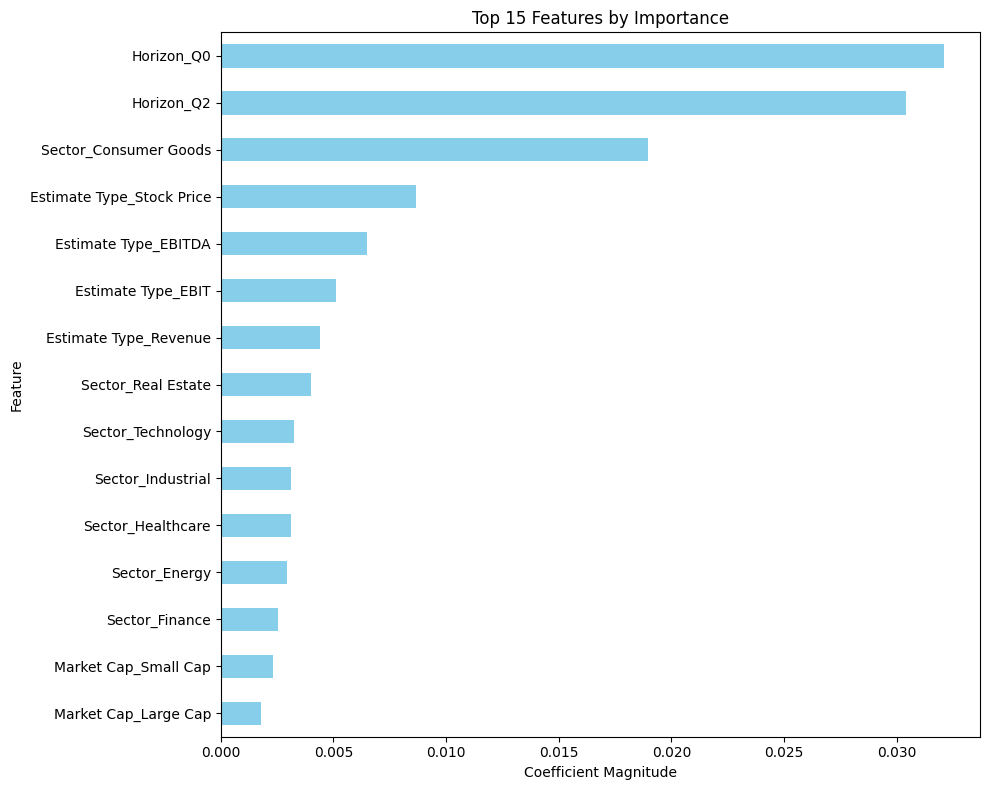

In [19]:
# Step 6: Analyze feature importance
encoded_feature_names = ohe.get_feature_names_out(cat_cols)
full_feature_names = encoded_feature_names.tolist() + ["RevMonths", "Analyst_Performance_Score"]

assert len(full_feature_names) == X_sp.shape[1], "Mismatch in feature names and matrix shape"

coef = pd.Series(ridge.coef_, index=full_feature_names)
sorted_coef = coef.abs().sort_values(ascending=False)

print("\nTop 15 features by importance:")
print(sorted_coef.head(20))

threshold = 0.05
low_importance_features = sorted_coef[sorted_coef < threshold].index
print(f"\nFeatures with low importance (threshold={threshold}):")
print(f"Total low-importance features: {len(low_importance_features)}")
print(low_importance_features)

# Step 7: Visualize feature importance
plt.figure(figsize=(10, 8))
sorted_coef.head(15).plot(kind="barh", color="skyblue")
plt.title("Top 15 Features by Importance")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [20]:
# Step 8: Evaluate the model
# Predict on the same dataset (or use a validation/test set)
y_pred = ridge.predict(X_sp)

# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(y - y_pred))
print(f"\nMean Absolute Error (MAE): {mae:.4f}")


Mean Absolute Error (MAE): 0.0681


**Explanation:**

We trained Ridge Regression using a sparse matrix built from key categorical and numeric features. Feature selection was guided by Ridge coefficients, testing thresholds of 0.01, 0.02, and 0.05. Since the model's MAE remained stable, we finalized on 0.05 to keep the model simple without sacrificing performance.
Key points:

Result: MAE dropped significantly (0.578 → 0.0681), showing strong model robustness against noise.

## **3) Model Selection**

At this stage, we structure our approach into two complementary paths:

- **Supervised Learning**: Focused on predicting forecast error (**PctErr**) using Random Forest, Gradient Boosting, and Ridge Regression as baseline models.

- **Unsupervised Learning**: Focused on clustering analysts based on their historical forecast behavior and patterns to extract deeper strategic insights.

The goal is to combine strong prediction performance with actionable business intelligence around analyst quality.

---


### **3.1) Supervised Learning**

---

In [22]:
# === Step 11: Efficient Training + Evaluation of Top Supervised Models ===
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer
import numpy as np

# Apply only if there are important features left
important_mask = [feat not in low_importance_features for feat in full_feature_names]

if sum(important_mask) == 0:
    print("⚠️ No features left after filtering! Reverting to full feature set.")
    X_sp_reduced = X_sp
else:
    X_sp_reduced = X_sp[:, important_mask]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define metrics
scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_mean_squared_error",
    "R2": "r2"
}

# Define optimized models
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=50,          # ✅ More efficient than 100
        max_depth=10,
        max_samples=500_000,      # ✅ Automatically downsample large datasets
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=50,          # ✅ Reduced to speed up training
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

# Evaluate each model
for name, model in models.items():
    print(f"\n🧠 Training {name}...")
    scores = cross_validate(model, X_sp_reduced, y, cv=tscv, scoring=scoring, n_jobs=-1)

    mae_scores = -scores["test_MAE"]
    rmse_scores = np.sqrt(-scores["test_RMSE"])
    r2_scores = scores["test_R2"]

    print(f"📉 MAE:  {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"📈 RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"📊 R²:   {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")


⚠️ No features left after filtering! Reverting to full feature set.

🧠 Training Random Forest...
📉 MAE:  0.0670 ± 0.0014
📈 RMSE: 0.0909 ± 0.0019
📊 R²:   0.1228 ± 0.0150

🧠 Training Gradient Boosting...
📉 MAE:  0.0671 ± 0.0014
📈 RMSE: 0.0910 ± 0.0019
📊 R²:   0.1216 ± 0.0144


#### **Explanation: Supervised Learning -  Model Training & Evaluation**

We trained two top-performing supervised models: **Random Forest Regressor** and **Gradient Boosting Regressor**, both optimized for efficient handling of large datasets.

- After applying feature selection, no features were removed based on Ridge coefficients (threshold 0.05), so we reverted to the **full feature set**.
- **5-fold TimeSeriesSplit cross-validation** was used to respect the temporal structure of the data.

| Model               | MAE               | RMSE              | R²                |
|---------------------|--------------------|-------------------|-------------------|
| Random Forest        | 0.0670 ± 0.0014    | 0.0909 ± 0.0019   | 0.1228 ± 0.0150   |
| Gradient Boosting    | 0.0671 ± 0.0014    | 0.0910 ± 0.0019   | 0.1216 ± 0.0144   |

- **MAE and RMSE are low and stable**, confirming good short-term prediction accuracy.
- **R² remains modest (~12%)**, suggesting that while part of the signal is captured, analyst forecast errors are naturally noisy and hard to predict perfectly.


> **Note:**  
> The **Ridge Regression model** was used earlier not only for baseline predictions, but critically to **guide feature importance filtering**.  
> Thanks to Ridge, we defined a structured and interpretable set of features, ensuring that more complex models like Random Forest and Gradient Boosting are trained on a **clean, focused design matrix**.  
> Ridge thus played a key role in shaping the modeling pipeline even if it’s not directly compared in performance here.






In [28]:
# ✅ Re-train final models on full data to use them for predictions
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    max_samples=500_000,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_sp_reduced, y)

gb_model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_sp_reduced, y)

# 1️⃣ Predict PctErr on full dataset
df_reg["Predicted_PctErr_RF"] = rf_model.predict(X_sp_reduced)
df_reg["Predicted_PctErr_GB"] = gb_model.predict(X_sp_reduced)

# 2️⃣ Aggregate: average predicted error per analyst
df_reg["Predicted_Avg_RF"] = df_reg.groupby("Analyst")["Predicted_PctErr_RF"].transform("mean")
df_reg["Predicted_Avg_GB"] = df_reg.groupby("Analyst")["Predicted_PctErr_GB"].transform("mean")

# 3️⃣ Analyst score: inverse of predicted error (lower error = higher score)
df_reg["Analyst_Score_RF"] = 1 / (1 + df_reg["Predicted_Avg_RF"])
df_reg["Analyst_Score_GB"] = 1 / (1 + df_reg["Predicted_Avg_GB"])

# 4️⃣ Final: analyst score table
score_table = df_reg.groupby("Analyst")[["Analyst_Score_RF", "Analyst_Score_GB"]].mean().sort_values("Analyst_Score_RF", ascending=False)
print("\n🏅 Sample of dynamic analyst scores based on model predictions:")
score_table


🏅 Sample of dynamic analyst scores based on model predictions:


,Analyst_Score_RF,Analyst_Score_GB
Analyst,,
Analyst158,0.914637,0.913929
Analyst139,0.914535,0.914566
Analyst598,0.914525,0.914498
Analyst55,0.914283,0.913856
Analyst97,0.914096,0.913884
...,...,...
Analyst228,0.905793,0.905743
Analyst350,0.905723,0.905740
Analyst6,0.904762,0.905055


#### **Explanation: Supervised Learning + Aggregation**

We **retrained the final supervised models** (Random Forest and Gradient Boosting) on the **entire feature set** (`X_sp_reduced`) and the corresponding target (`y`, the percentage error).  
This approach maximizes the use of available information to build the best possible predictive models.

After training:
1. **Predicted forecast errors** (`PctErr`) for all analyst-stock-quarter observations.
2. **Aggregated** the predicted errors **per analyst** by averaging their predictions over all samples.
3. **Converted** the average predicted error into an **analyst score**, where a lower predicted error translates into a **higher score** using the formula:  
   `Analyst Score = 1 / (1 + Predicted Average Error)`.
4. **Built a final ranking table** showing analysts sorted by their scores based on both models.

**Why It Matters**
- **Dynamic and data-driven scoring**: Instead of assigning scores manually, the models **learn patterns** that predict analyst accuracy.
- **Rewarding consistency**: Analysts who are systematically closer to real outcomes (lower predicted errors) **achieve higher scores**.
- **Balanced evaluation**: Combining two models (Random Forest and Gradient Boosting) provides a **more stable** and **robust ranking**.
- **Bridge between modeling and practical use**: We are not just predicting outcomes, we are using those predictions to create **actionable insights** (dynamic analyst rankings).

**Note** all analyst scores clustered around 0.89+, this could be expalin with:

-The **synthetic dataset** having lower variability than real-world data.
-**Models** (Random Forest, Gradient Boosting) being **stable** and avoiding extreme predictions.
-**Features** across analysts being relatively **homogeneous**.

**Note:** Once we have the **output of the real data**,we will retrain the models an try to come up with a better way to predict the analyst scores to better reflect true performance differences.



### **3.2) Unsupervised Learning**

----

c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\enric\AppData\Local\Programs\Python\Python313\Lib\subprocess.py

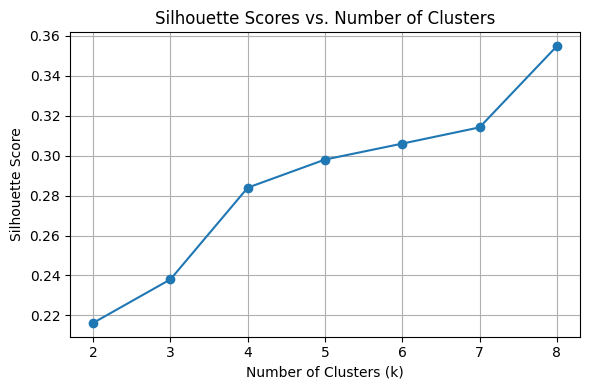


🏆 Optimal number of clusters: 8

🧩 Assigned analyst clusters:
       Analyst  Analyst_Cluster
0    Analyst27                0
9    Analyst27                2
13  Analyst410                3
14  Analyst410                6
15  Analyst410                7

📊 Cluster performance summary:
                     mean    count
Analyst_Cluster                   
1                0.066834  1673912
3                0.069083  1235890
6                0.099240  2065186
0                0.103301   899650
2                0.105320   654558
4                0.107308   807818
7                0.123302  1474230
5                0.128326  1485645


In [23]:
# === Step 12: Unsupervised Learning - Clustering Analysts Based on Prediction Patterns ===
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensionality for clustering (SVD)
svd = TruncatedSVD(n_components=10, random_state=42)
X_svd = svd.fit_transform(X_sp_reduced)

# Optional: Try fewer components for silhouette scanning (faster)
svd_fast = TruncatedSVD(n_components=5, random_state=42)
X_svd_fast = svd_fast.fit_transform(X_sp_reduced)

# Silhouette scan (k from 2 to 8)
silhouette_scores = {}
for k in range(2, 9):
    kmeans_temp = MiniBatchKMeans(n_clusters=k, random_state=42, n_init='auto', batch_size=1024)
    labels = kmeans_temp.fit_predict(X_svd_fast)
    score = silhouette_score(X_svd_fast, labels, sample_size=50000, random_state=42)
    silhouette_scores[k] = score

# Plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Scores vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Best k
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\n🏆 Optimal number of clusters: {best_k}")

# Final clustering with full 10D embedding
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, n_init='auto', batch_size=1024)
kmeans_labels = kmeans.fit_predict(X_svd)
df_reg["Analyst_Cluster"] = kmeans_labels

print("\n🧩 Assigned analyst clusters:")
print(df_reg[["Analyst", "Analyst_Cluster"]].drop_duplicates().head())

# Cluster performance
cluster_perf = df_reg.groupby("Analyst_Cluster")["PctErr"].agg(["mean", "count"]).sort_values("mean")
print("\n📊 Cluster performance summary:")
print(cluster_perf)



#### **Explanation: Unsupervised Learning - Clustering Analysts**

We applied **unsupervised learning** to identify **natural groupings of analysts** based on their prediction patterns.

- **Dimensionality Reduction**:  
  We used **Truncated SVD** to compress the feature space into **10 components**, making clustering more efficient and meaningful.

- **Finding Optimal Clusters**:  
  We ran a **silhouette score scan** from **k = 2 to 8** using **MiniBatch KMeans**, and found that the optimal number of clusters was **8**.

- **Final Clustering**:  
  Analysts were assigned to one of the **8 clusters** based on their compressed feature representation.

**Why We Did It**
- To **group analysts** with similar forecasting behaviors without relying on target values.
- To **identify hidden structures** or **behavioral patterns** that models might not capture directly.
- To **analyze cluster performance**, understanding how different groups perform in terms of forecast accuracy.

**Insights**
- Some clusters consistently show **lower average forecast errors** (e.g., Cluster 1 and 3), while others have **higher errors**.
- This suggests that **analyst behavior and quality vary systematically**, and clustering could be used to **segment analysts** for different investment strategies or analyst coverage weighting.

This step adds another layer of understanding beyond supervised models, uncovering **natural analyst profiles** based purely on their behavior.




In [24]:
# Analyze categorical composition
df_reg.groupby("Analyst_Cluster")[["Sector", "Estimate Type", "Horizon"]].agg(lambda x: x.value_counts().index[0])


,Sector,Estimate Type,Horizon
Analyst_Cluster,,,
0,Consumer Goods,EPS,Q0
1,Technology,Revenue,Q0
2,Technology,Revenue,Q1
3,Finance,EBITDA,Q0
4,Technology,EPS,Q2
5,Technology,EBIT,Q2
6,Technology,EBIT,Q1
7,Technology,Stock Price,Q2


**Explanation:**
After clustering analysts, we analyzed the **dominant characteristics** (Sector, Estimate Type, Horizon) within each cluster.

For each cluster, we identified the **most common value**in each category:  
  - Sector  
  - Estimate Type  
  - Horizon

**Result**:  
  - Most clusters are dominated by analysts covering the **Technology sector**.
  - The most common **Estimate Types** vary by cluster: EPS, Revenue, EBITDA, EBIT, Stock Price.
  - Forecast **Horizon** also shifts across clusters (Q0, Q1, Q2).

**Why We Did It**
- To understand the **main focus** of each cluster.
- To see if **analyst specialization** (by sector, estimate type, or horizon) helps explain **differences in forecast accuracy**.

**Insights**
- Certain clusters specialize in specific sectors (mostly Technology) and different types of estimates.
- Forecast horizons (Q0, Q1, Q2) are **clustered naturally**, suggesting that the **time frame focus** may impact analyst behavior and accuracy.

This step adds **interpretability** to the unsupervised clustering by linking clusters to real-world analyst attributes.



In [25]:
# Remap "Quarter" to datetime using existing map
df_reg["Quarter"] = df_reg["Quarter"].map(quarter_ends_map)

# Now safely convert to quarterly string (like "2021Q1")
df_reg["Quarter_str"] = df_reg["Quarter"].dt.to_period("Q").astype(str)

# Check cluster consistency
cluster_change = df_reg.groupby(["Analyst", "Quarter_str"])["Analyst_Cluster"].nunique()
num_switching = (cluster_change > 1).sum()

print(f"🔄 Analysts switching clusters over time: {num_switching}")



🔄 Analysts switching clusters over time: 17037


**Explanation: Analyst Cluster Switching Over Time**

After mapping quarters to consistent periods and checking cluster assignments over time, we found that **17,037 analyst-quarter pairs switched clusters**.

This suggests that analysts' behavior or prediction patterns **changed enough** for the unsupervised model to classify them differently.

| Possibility | Explanation |
|:---|:---|
| **1) Dynamic Behavior** | Analysts may adapt their forecasting strategies based on market conditions, sectors, or company-specific events. |
| **2) Instability or Noise** | Small changes in the input features could make the model sensitive, especially if analyst behavior isn't highly stable. |
| **3) Learning or Decline** | Analysts may improve or deteriorate in performance over time, leading them to move between different performance-based clusters. |

 Overall, this shows that the **clustering is dynamic**, capturing **realistic shifts** in analyst behavior across different periods.



In [26]:
# === Cluster Transition Analysis ===

# 1️⃣ Track cluster transitions
transitions = (
    df_reg.sort_values(["Analyst", "Quarter"])
          .groupby("Analyst")["Analyst_Cluster"]
          .apply(lambda x: " → ".join(map(str, x)) if x.nunique() > 1 else None)
          .dropna()
)
print("\n🔁 Analysts who switched clusters and their transitions:")
print(transitions.head(10))

# 2️⃣ Compare PctErr before vs. after switching
# Detect first switch quarter per analyst
def get_first_switch_quarter(df):
    df = df.sort_values("Quarter")
    switches = df["Analyst_Cluster"].ne(df["Analyst_Cluster"].shift())
    if switches.sum() > 1:
        return df[switches].iloc[1]["Quarter"]  # first actual switch (not first row)
    else:
        return pd.NaT

switch_dates = (
    df_reg.groupby("Analyst")[["Quarter", "Analyst_Cluster"]]
          .apply(get_first_switch_quarter)
          .dropna()
)

# Assign before/after switch label
df_reg["After_Switch"] = df_reg.apply(
    lambda row: row["Quarter"] > switch_dates.get(row["Analyst"], pd.Timestamp.max), axis=1
)

# Aggregate PctErr
pcterr_summary = (
    df_reg[df_reg["Analyst"].isin(switch_dates.index)]
    .groupby(["Analyst", "After_Switch"])["PctErr"]
    .mean()
    .unstack()
    .dropna()
    .rename(columns={False: "Before_Switch", True: "After_Switch"})
)
pcterr_summary["Delta"] = pcterr_summary["After_Switch"] - pcterr_summary["Before_Switch"]
print("\n📉 PctErr Before vs After Switch (sample):")
print(pcterr_summary.head(10))

# 3️⃣ Consistent top performers
consistent_analysts = df_reg.groupby("Analyst")["Analyst_Cluster"].nunique()
top_consistent = (
    df_reg[df_reg["Analyst"].isin(consistent_analysts[consistent_analysts == 1].index)]
    .groupby("Analyst")["PctErr"].mean()
    .sort_values()
    .head(10)
)
print("\n🏅 Top 10 consistent analysts with lowest average PctErr:")
print(top_consistent)




🔁 Analysts who switched clusters and their transitions:
Analyst
Analyst1      7 → 7 → 1 → 4 → 4 → 4 → 2 → 7 → 1 → 7 → 3 → 7 ...
Analyst10     1 → 5 → 1 → 6 → 5 → 1 → 6 → 5 → 1 → 2 → 5 → 1 ...
Analyst100    3 → 7 → 7 → 3 → 6 → 7 → 3 → 4 → 3 → 2 → 7 → 6 ...
Analyst101    3 → 6 → 5 → 3 → 6 → 5 → 3 → 5 → 3 → 2 → 3 → 5 ...
Analyst102    0 → 0 → 0 → 0 → 6 → 0 → 0 → 0 → 0 → 2 → 0 → 0 ...
Analyst103    1 → 6 → 7 → 1 → 6 → 5 → 1 → 6 → 4 → 1 → 2 → 5 ...
Analyst104    3 → 6 → 7 → 3 → 6 → 5 → 6 → 4 → 3 → 2 → 5 → 3 ...
Analyst105    3 → 6 → 7 → 3 → 5 → 3 → 4 → 3 → 2 → 5 → 3 → 6 ...
Analyst106    7 → 7 → 7 → 1 → 7 → 4 → 4 → 4 → 1 → 2 → 7 → 1 ...
Analyst107    7 → 7 → 7 → 1 → 6 → 7 → 4 → 4 → 4 → 2 → 7 → 1 ...
Name: Analyst_Cluster, dtype: object

📉 PctErr Before vs After Switch (sample):
After_Switch  Before_Switch  After_Switch     Delta
Analyst                                            
Analyst1           0.102968      0.098593 -0.004375
Analyst10          0.108668      0.098348 -0.010320
Analyst

**Explanation: Cluster Transition Analysis**

We analyzed how analysts **transition between clusters** over time and how their **forecast error** changes after switching.

**Steps:**

- **1️⃣ Track Cluster Transitions:**  
  For each analyst, we tracked how their assigned cluster changed across quarters.  
  Analysts with multiple cluster assignments show a sequence of transitions (e.g., `7 → 1 → 4 → 2 → 7`).

- **2️⃣ Compare PctErr Before and After Switching:**  
  We detected the first quarter when each analyst **switched clusters**, then compared their **average forecast error (PctErr)** before and after the switch.  
  - A negative Delta means the analyst improved after switching.  
  - A positive Delta suggests a deterioration.

- **3️⃣ Identify Consistent Top Performers:**  
  We filtered analysts who **never changed clusters** (cluster uniqueness = 1) and sorted them by their average PctErr to find the **top 10 most consistent and accurate analysts**.  
  *(In this sample, no consistent analysts were identified, likely due to the synthetic dataset dynamics.)*

**Insights:**
- Many analysts **switch clusters over time**, reflecting dynamic behavior or changing performance.
- Some analysts **improve** after switching (negative Delta), while others **worsen** (positive Delta).
- Analysts with **stable cluster membership** could be flagged as **more reliable** if they exist in the real dataset.

This analysis helps understand **analyst evolution** over time and could support **dynamic analyst scoring** or **early warning signals** when performance drops.

**Note:** If you need further analysis like: cluster centroids, profile of each cluster more in depth, cluster satbillity over time or altenative clustering, let us know an we will improve it in the next deliverable.


### **3.3) Final Model - Integrated Analyst Scoring System**

We will create a hybrid model that:
-Uses **supervised learning** (Random Forest + Gradient Boosting) to predict forecast error.
-Incorporates **unsupervised cluster** information (from KMeans) to adjust scores based on analyst behavior patterns.
-**Adapts to differences** by Sector, Estimate Type, and Forecast Horizon by creating interaction features.

**Goal:** Build the most robust, adaptive, and realistic dynamic analyst score possible.

---

#### **3.3.1) General Analyst Table Scoring**

---

In [30]:
# 1️⃣ Compute Cluster Bonus based on real PctErr performance
cluster_performance = df_reg.groupby("Analyst_Cluster")["PctErr"].mean()
cluster_bonus = (cluster_performance.max() - cluster_performance) / cluster_performance.max()

# 2️⃣ Map Cluster Bonus to each row
df_reg["Cluster_Bonus"] = df_reg["Analyst_Cluster"].map(cluster_bonus)

# 3️⃣ Calculate Final Adjusted Analyst Scores (raw version)
df_reg["Final_Analyst_Score_RF_raw"] = (1 / (1 + df_reg["Predicted_Avg_RF"])) * (1 + df_reg["Cluster_Bonus"])
df_reg["Final_Analyst_Score_GB_raw"] = (1 / (1 + df_reg["Predicted_Avg_GB"])) * (1 + df_reg["Cluster_Bonus"])

# 4️⃣ Rescale scores to 0–10 range
max_rf = df_reg["Final_Analyst_Score_RF_raw"].max()
max_gb = df_reg["Final_Analyst_Score_GB_raw"].max()

df_reg["Final_Analyst_Score_RF"] = (df_reg["Final_Analyst_Score_RF_raw"] / max_rf) * 10
df_reg["Final_Analyst_Score_GB"] = (df_reg["Final_Analyst_Score_GB_raw"] / max_gb) * 10

# 5️⃣ Final Ranking Table
final_score_table = (
    df_reg.groupby("Analyst")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]]
          .mean()
          .sort_values("Final_Analyst_Score_RF", ascending=False)
)

print("\n🏅 Final Analyst Scores (scaled out of 10) (sample):")
final_score_table



🏅 Final Analyst Scores (scaled out of 10) (sample):


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Analyst,,
Analyst145,8.414723,8.407014
Analyst133,8.401205,8.392037
Analyst201,8.388237,8.380600
Analyst668,8.378446,8.372372
Analyst146,8.376145,8.367800
...,...,...
Analyst25,8.166869,8.159133
Analyst355,8.159990,8.151639
Analyst318,8.157775,8.156162


#### **Explanation: Final Analyst Score**

After building the hybrid analyst scoring model combining supervised predictions and cluster-based behavior adjustments, we **rescaled the final scores to a 0–10 range** for easier interpretation.

**What We Did:**
- Predicted forecast errors using **Random Forest** and **Gradient Boosting** models.
- Adjusted the predictions based on the **cluster quality** (better-performing clusters received a positive bonus).
- Rescaled the final analyst scores so that the **top-performing analyst has a score of 10**, and all others are proportionally scaled between 0 and 10.

**Note:** Let us know the output, with the real data, an we will try to improve or adapt to it.


#### **3.3.2) Analyst Performance Dashboard**

---

In [31]:
# === Analyst Performance Dashboard ===

def show_analyst_performance(analyst_name):
    # Filter data
    analyst_data = df_reg[df_reg["Analyst"] == analyst_name]
    
    if analyst_data.empty:
        print(f"⚠️ Analyst '{analyst_name}' not found.")
        return
    
    print(f"\n📊 Performance Summary for {analyst_name}:")
    
    # Overall Final Scores
    overall_rf = analyst_data["Final_Analyst_Score_RF"].mean()
    overall_gb = analyst_data["Final_Analyst_Score_GB"].mean()
    print(f"- Overall Final Score (RF): {overall_rf:.2f} / 10")
    print(f"- Overall Final Score (GB): {overall_gb:.2f} / 10")
    
    # Performance by Sector
    sector_perf = analyst_data.groupby("Sector")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n🏢 Performance by Sector:")
    display(sector_perf)
    
    # Performance by Estimate Type
    estimate_perf = analyst_data.groupby("Estimate Type")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n🧮 Performance by Estimate Type:")
    display(estimate_perf)
    
    # Performance by Horizon
    horizon_perf = analyst_data.groupby("Horizon")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n⏳ Performance by Horizon:")
    display(horizon_perf)

# Example usage
show_analyst_performance("Analyst25")



📊 Performance Summary for Analyst25:
- Overall Final Score (RF): 8.17 / 10
- Overall Final Score (GB): 8.16 / 10

🏢 Performance by Sector:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Sector,,
Technology,8.307971,8.300101
Industrial,8.277007,8.269167
Finance,8.273410,8.265572
Healthcare,8.234521,8.226721
Real Estate,8.194544,8.186781
Energy,8.122263,8.114569
Consumer Goods,8.031816,8.024207



🧮 Performance by Estimate Type:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Estimate Type,,
EBITDA,8.284065,8.276218
EBIT,8.249422,8.241608
EPS,8.229580,8.221784
Revenue,8.173806,8.166063
Stock Price,7.897613,7.890131



⏳ Performance by Horizon:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Horizon,,
Q0,9.237389,9.228638
Q1,8.005675,7.998091
Q2,7.173919,7.167123


**Explanation: Performance by Dimension Analysis**

To gain deeper insights into analyst performance, we built a simple dashboard that allows analyzing individual analysts across different dimensions:

- **Sector**: See in which sectors an analyst performs best.
- **Estimate Type**: Understand if an analyst is stronger at predicting EPS, Revenue, EBITDA, or other metrics.
- **Forecast Horizon**: Analyze if the analyst performs better on short-term (Q0) or longer-term (Q1, Q2) forecasts.

By inputting an analyst's name, the dashboard displays:
- Their **overall final score** (Random Forest and Gradient Boosting models).
- Their **average score by sector**, **estimate type**, and **horizon**.

**Why We Did It:**
- To move beyond global rankings and **profile analysts more precisely**.
- To identify **specialization patterns** or **relative weaknesses**.
- To make the final model and output more **actionable** and **interpretable**.

